In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

#Torch: 
import torch
import torchaudio
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import transformers

#Audio
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

from pydub import AudioSegment
from pydub.playback import play
from glob import glob

from pathlib import Path
import gc
import re
from imblearn.over_sampling import RandomOverSampler
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
from datasets import Dataset, ClassLabel

from os.path import isfile, isdir, dirname
from os import mkdir
import os


#for midi:
#import pyfluidsynth


#import datasets
#import transformers
##import mir_eval.sonify
#from itertools import cycle



tqdm.pandas()
from pathlib import Path


from os.path import isfile, isdir, dirname
from os import mkdir
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from pydub import AudioSegment



In [4]:
RATE_HZ = 16000 # resampling rate in Hz
MAX_LENGTH = 480000 # maximum audio interval length to consider (= RATE_HZ * SECONDS)
labels = ['cuphead', 'minecraft', 'undertale', 'doom', 'kirby', 'celeste', 'rocket league', 'stardew valley']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'cuphead', 1: 'minecraft', 2: 'undertale', 3: 'doom', 4: 'kirby', 5: 'celeste', 6: 'rocket league', 7: 'stardew valley'} 

 {'cuphead': 0, 'minecraft': 1, 'undertale': 2, 'doom': 3, 'kirby': 4, 'celeste': 5, 'rocket league': 6, 'stardew valley': 7}


In [5]:
def load_data():
    file_list = []
    label_list = []
    for folder in Path(r'./30 sec train').glob('*'):
        for file in Path(folder).glob('*.wav'):
            file_list.append(file)
            label_list.append(label2id[str(folder).split('\\')[1]])
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['label'] = label_list
    return dd
dd = load_data()


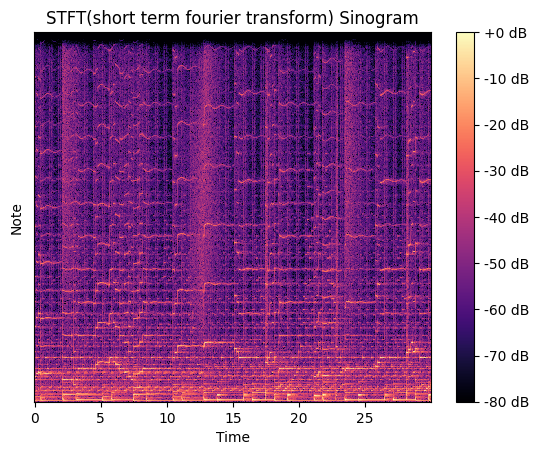

In [6]:
sig, rate = librosa.load(dd['file'][1])
S = librosa.stft(sig)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db,sr=rate, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('STFT(short term fourier transform) Sinogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

(252, 1292)


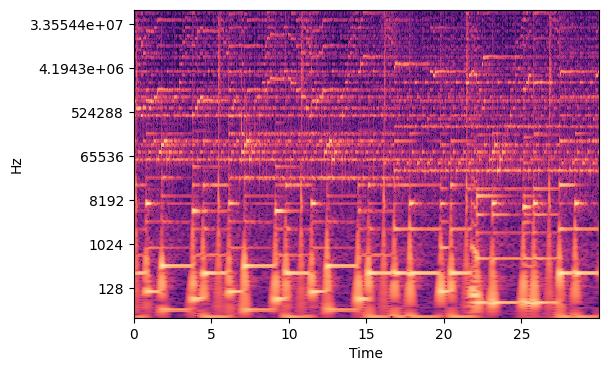

In [ ]:
BINS_PER_OCTAVE = 12*3
N_OCTAVE = 7
wavey = dd["file"][3]
sig, rate = librosa.load(wavey)
C = np.abs(librosa.cqt(sig, sr=rate,bins_per_octave=BINS_PER_OCTAVE,n_bins=N_OCTAVE*BINS_PER_OCTAVE))
C_db = librosa.amplitude_to_db(C, ref=np.max,)



# Plot the spectrogram
plt.figure(figsize=(6, 4))
print(C_db.shape)
librosa.display.specshow(C_db, x_axis="time", y_axis="cqt_hz")


(1025, 646)


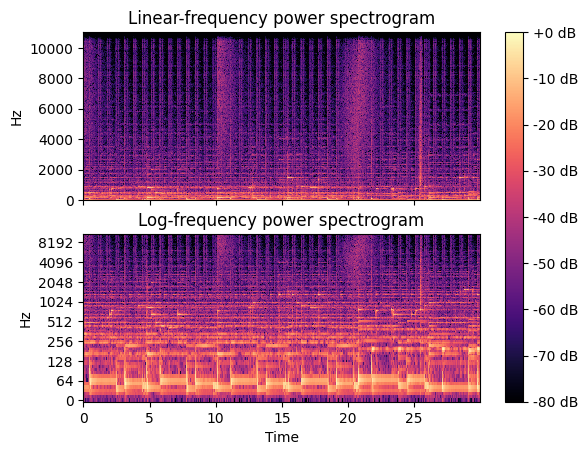

In [11]:
y, sr = librosa.load(dd['file'][5])
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
print(D.shape)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

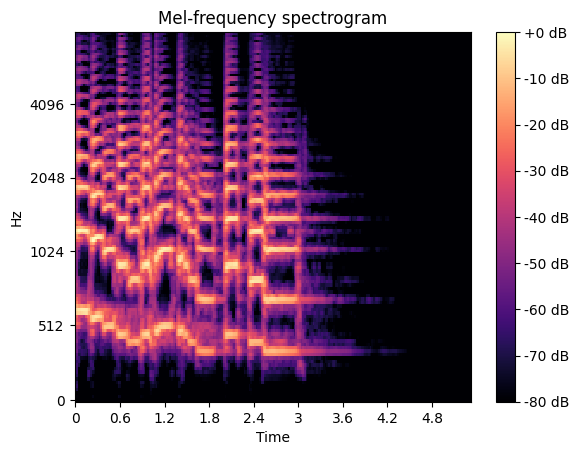

In [13]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [14]:
Audio_base_dir = "./game songs"
for label in os.listdir(Audio_base_dir):
    label_folder = os.path.join("./30 sec train", str(label))
    os.makedirs(label_folder, exist_ok=True)

In [ ]:
from pydub import AudioSegment
label_count = np.zeros(8)
#(30 seconds = 30000 ms)
chunk_duration_ms = 30000

for index, file in enumerate(dd['file']):
    sound = AudioSegment.from_file(file)
    num_chunks = len(sound) // chunk_duration_ms
    label = str(file).split('\\')[1]
    id = label2id[label]
    label_count[id] += num_chunks
for index,value in enumerate(label_count):
    print(id2label[index],": ",value)

cuphead :  118.0
minecraft :  118.0
undertale :  109.0
doom :  120.0
kirby :  110.0
celeste :  122.0
rocket league :  120.0
stardew valley :  121.0


In [ ]:
#pip install ffmpeg


#(30 seconds = 30000 ms)
chunk_duration_ms = 30000

# Split the audio into chunks and export
for index, file in enumerate(dd['file']):
    sound = AudioSegment.from_file(file)
    label = str(file).split('\\')[1]
    num_chunks = len(sound) // chunk_duration_ms
    for i in range(num_chunks):
        start_time = i * chunk_duration_ms
        end_time = start_time + chunk_duration_ms
        audio_chunk = sound[start_time:end_time]  # Slice the audio
        
        # Save the chunk as a wav file
        save_path = os.path.join(".\\30 sec train\\", label,  label + f"song_num_{index},sample_{i}.wav")
        # audio_chunk.export(save_path, format="wav")

In [9]:
#will be at the same folder as this vs file.
spectrogram_base_dir = ".\\CQT spectrograms"
os.makedirs(spectrogram_base_dir, exist_ok=True)        #if not existed then i will create the folder

#Extract filename without path or extension
List_Of_Filenames = [str(file).split('\\')[1] for file in dd["file"]]    #it will give us the name of each file (pop.0001, ...)

#-------------------------------------------------------------------------------------------------------
#folder for each Label.
for label in range(len(labels)):
    label_folder = os.path.join(spectrogram_base_dir, str(id2label[label]))
    os.makedirs(label_folder, exist_ok=True)

# # Loop through the audio files and save spectrograms
for index, file in enumerate(dd['file']):
    # Define save path
    sig, rate = librosa.load(file)
    
    C = np.abs(librosa.cqt(sig, sr=rate,bins_per_octave=BINS_PER_OCTAVE,n_bins=N_OCTAVE*BINS_PER_OCTAVE))
    C_db = librosa.amplitude_to_db(C, ref=np.max)
    
    spectrogram_label_dir = os.path.join(spectrogram_base_dir, str(file).split('\\')[1])
    save_path = os.path.join(spectrogram_label_dir,f"{index}.npy")
    # Plot and save the spectrogram
    np.save(file=save_path,arr=C_db)

print("All spectrograms saved successfully!")

All spectrograms saved successfully!
